In [3]:
import seaborn as sns

import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
from imageio import imread
import marginal

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


import joblib

def read_grayscale_pngs(path, width=20, height=13):
    path = Path(path)
    if not path.exists():
        print("Path doesn't exist")
        return None

    # print(len([name for name in os.listdir('{}/.'.format(path)) if os.path.isfile(name)]))
    num_files = len(list(path.glob('**/*.png'))) # Calculate amount of files in directory
    # num_files = len([f for f in path.iterdir() if path.joinpath(f).is_file()]) # Calculate amount of files in directory

    ids = np.empty(num_files)
    images = np.empty((num_files, 13, 20))

    for i, image_path in enumerate(path.glob('**/*.png')):
        images[i] = np.array(imread(image_path))[:, :, 0] # Pixel data: It's grayscale so take only Red values from [R, G, B, A]
    return images

In [12]:
legal = read_grayscale_pngs("out/legal/orig")
illegal = read_grayscale_pngs("out/illegal/orig")

legal_test = read_grayscale_pngs("testing/legal")
illegal_test = read_grayscale_pngs("testing/illegal")


In [13]:
from scipy import ndimage
import operator
from scipy.ndimage.interpolation import rotate

def rotate_image(image, angle):
    rotated = ndimage.rotate(image, angle, mode='nearest')

    orig_average = weighted_average_indexes(image)

    rotated_average = weighted_average_indexes(rotated)
    if orig_average is None or rotated_average is None:
        return None

    # Shift the image so the center is at the same place
    center_diff = tuple(map(operator.sub, orig_average, rotated_average))
    median_value = np.median(rotated)

    shifted = ndimage.shift(rotated, np.array([center_diff[1], center_diff[0]]), cval=median_value)

    # Crop the image since it got bigger by rotation, it's centered so cutting the rest is enough
    return shifted[: image.shape[0], : image.shape[1]]


def weighted_average_indexes(image):
    # Values below 35 are not substantial and they mess with the average so replace them with zero
    image[image < 35] = 0
    total = np.sum(image) 

    if np.all(total == 0):
        return None

    val = 0
    for index, xsum in enumerate(np.sum(image, axis=0)):
        val += index * xsum
    xpos = val / total 

    val = 0
    for index, ysum in enumerate(np.sum(image, axis=1)):
        val += index * ysum
    ypos = val / total

    return xpos, ypos

In [14]:
features_list = []
for i, dataset in enumerate((legal, illegal, legal_test, illegal_test)):
    features = pd.DataFrame({
        "min": np.min(dataset, axis=(1,2)),
        "max": np.max(dataset, axis=(1,2)),
        "mean": np.mean(dataset, axis=(1,2)),
        "var": np.var(dataset, axis=(1,2)),
        "sum": np.sum(dataset, axis=(1,2)),
        "ptp": np.ptp(dataset, axis=(1,2)),
        "std": np.std(dataset, axis=(1,2)),
        "trace": np.trace(dataset, axis1=1, axis2=2),

        "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in dataset]),
        "mmeanxTF": np.array([marginal.mean(image, dim='x', meanNN_TF=True) for image in dataset]),

        "msdx": np.array([marginal.std(image, dim='x', meanNN_TF=False) for image in dataset]),
        "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in dataset]),

        "mmeany": np.array([marginal.mean(image, dim='y', meanNN_TF=False) for image in dataset]),
        "mmeanyTF": np.array([marginal.mean(image, dim='y', meanNN_TF=True) for image in dataset]),

        "msdy": np.array([marginal.std(image, dim='y', meanNN_TF=False) for image in dataset]),
        "msdyTF": np.array([marginal.std(image, dim='y', meanNN_TF=True) for image in dataset]),

        "target": 0 if i % 2 == 0 else 1
    })
    features_list.append(features)

legal_features, illegal_features, legal_test_features, illegal_test_features = tuple(features_list)


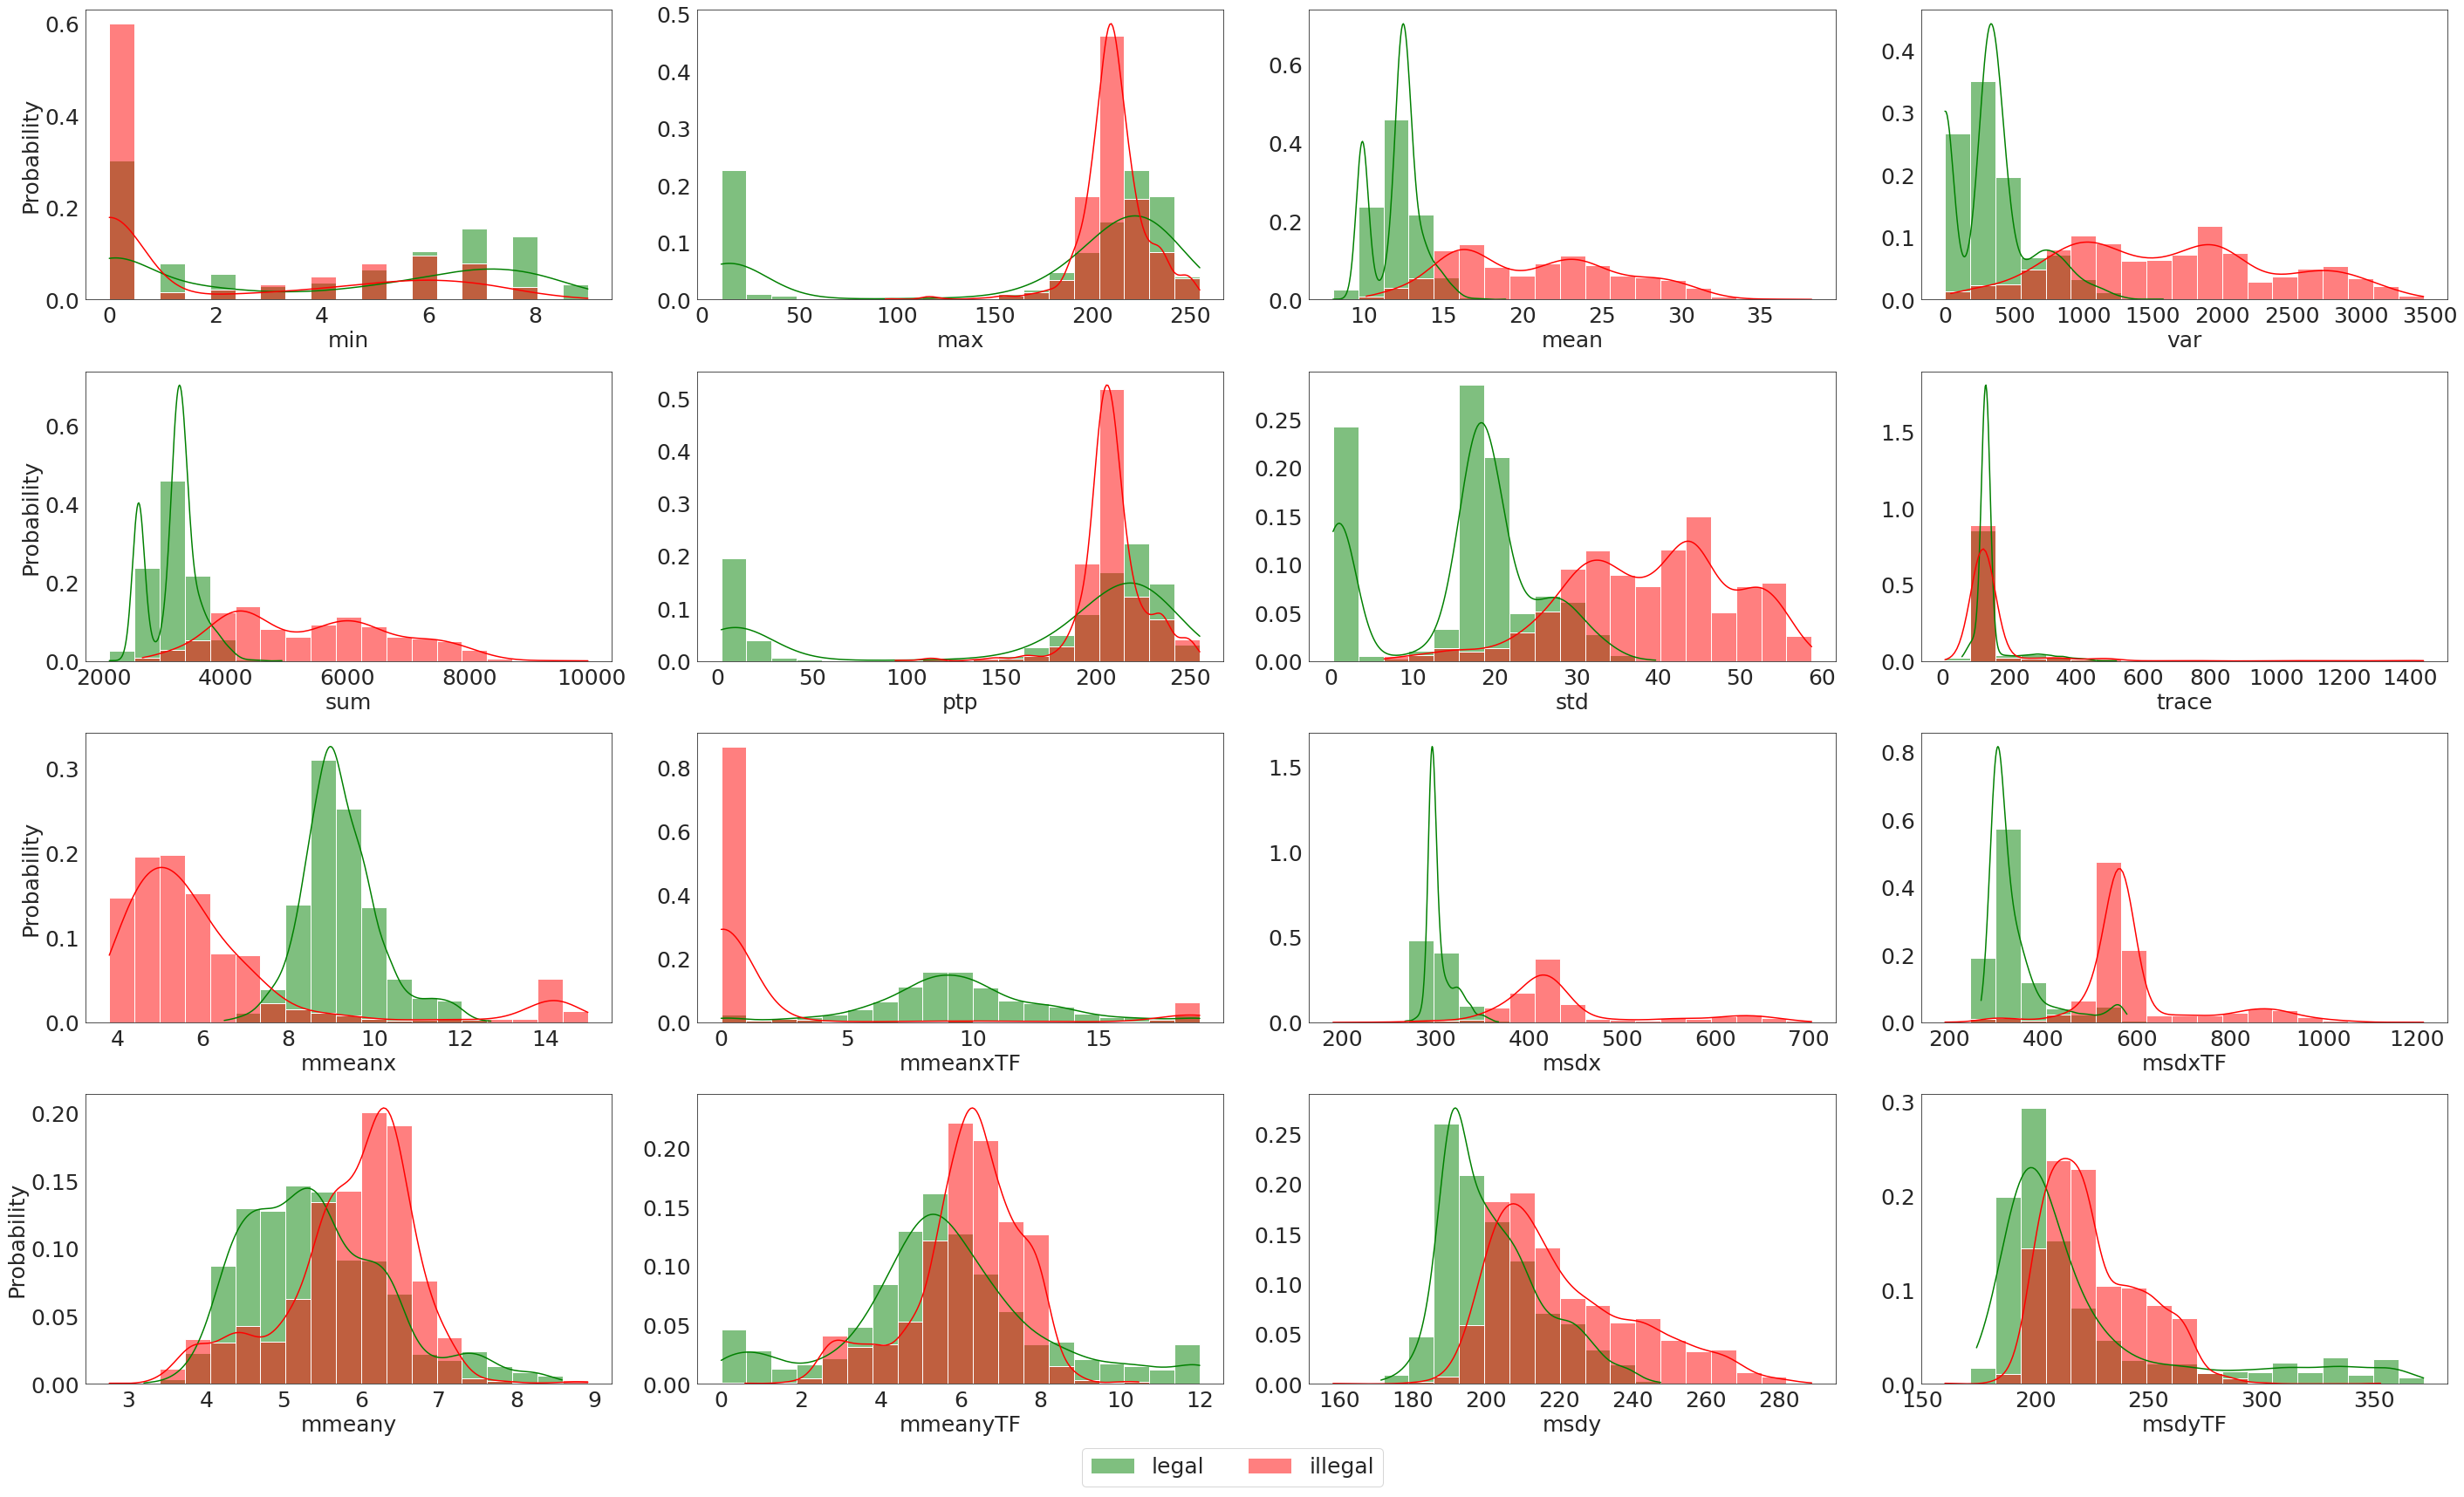

In [18]:
fig = plt.figure(figsize=(40, 25))
plt.rcParams.update({'font.size': 25})
n_bins = 20
i = 1
sns.set_style(style = 'white')

for feature in features.columns[: features.columns.slice_locs(end='msdyTF')[1]]: # Cycle through columns until and including "trace"
    ax = plt.subplot(4, 4, i)
    bins = np.linspace(features[feature].min(), features[feature].max(), n_bins)
    sns.histplot(data=legal_features, x=feature, kde=True, bins=bins, stat="probability", color='g', label='legal', ax=ax)
    sns.histplot(data=illegal_features, x=feature, kde=True, bins=bins, stat="probability", color='r', label='illegal', ax=ax)
    if i % 4 != 1:
        plt.ylabel(None)
    i += 1
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2)
fig.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.075)
plt.savefig('figures/ml_feature_distribution.pdf')

<Figure size 2160x2880 with 0 Axes>

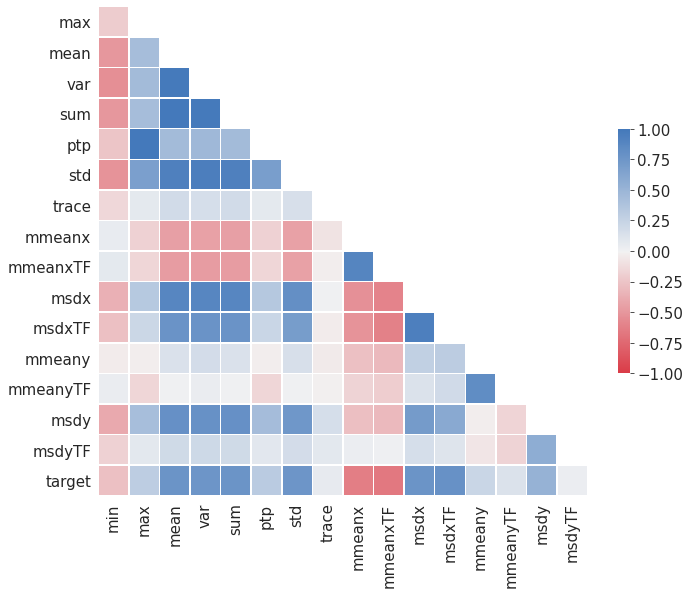

In [19]:
plt.figure(figsize=(30,40))

corr = features.corr().iloc[1: , :-1]
mask = np.triu(np.ones_like(corr, dtype=np.bool), k=1)
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
        square=True, vmin=-1.0, vmax=1.0,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.savefig('figures/ml_feature_corr.pdf')

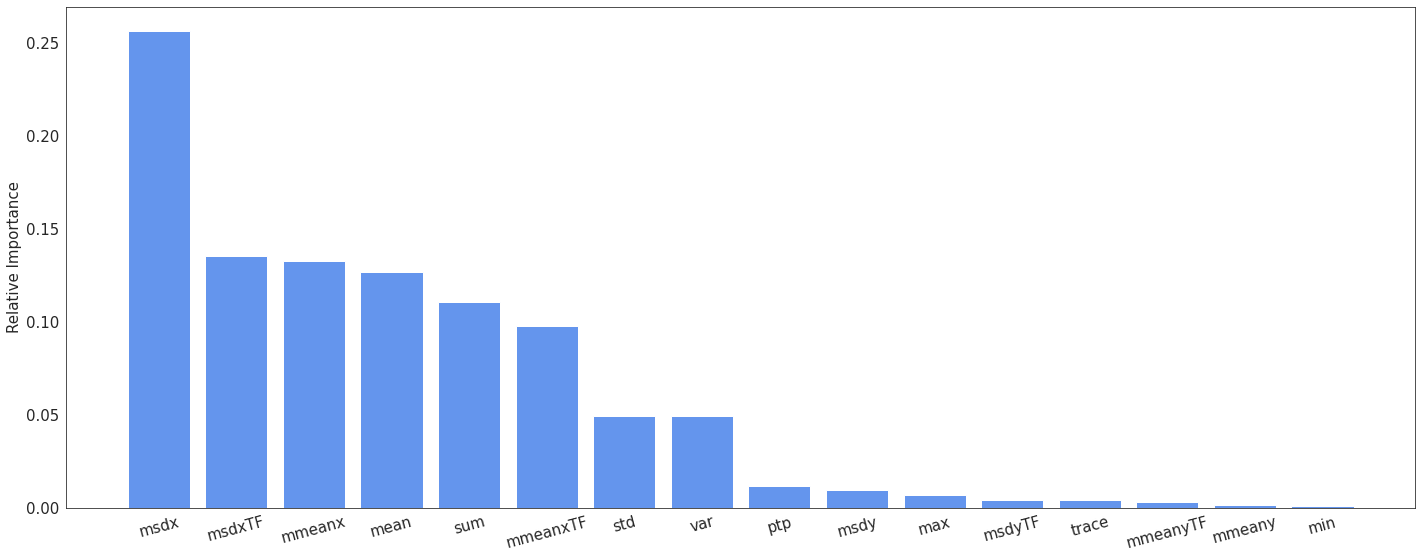

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split# Spliiting data into test and train sets

# X_train, X_test, y_train, y_test = train_test_split(features.drop('target', axis=1), features['target'], test_size=0.20, random_state=0)# fitting the model
model = RandomForestClassifier(n_estimators=200)

# X_train = features.drop('target', axis=1)
# Y_train = features['target']


features_selected =  []

X_train = features.drop('target', axis=1) if len(features_selected)==0 else features[features_selected]
Y_train = features['target']

model.fit(X_train, Y_train)# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.xticks(range(len(indices)), [features_forest[i] for i in indices], rotation=15)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.savefig("figures/ml_feature_importances.pdf")
plt.show()



In [ ]:
plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.xticks(range(len(indices)), [features_forest[i] for i in indices], rotation=15)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.savefig("figures/ml_feature_importances.pdf")
plt.show()

In [21]:
X_train = features.drop('target', axis=1)
Y_train = features['target']

X_test = test_features.drop('target', axis=1)
Y_test = test_features['target']

model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, Y_train)# plotting feature importances

Y_pred = model.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

confusion_matrix = confusion_matrix(test_features['target'], Y_pred)

Accuracy of random forest classifier on test set: 0.99


In [22]:
X_train = features.drop('target', axis=1)
Y_train = features['target']

X_test = test_features.drop('target', axis=1)
Y_test = test_features['target']

from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [ ]:
features[features_forest[indices][ifrom:]]

NameError: name 'ifrom' is not defined

In [ ]:
features.max()

min             19.000000
max            255.000000
mean            46.207692
var           3451.601775
sum          12014.000000
ptp            255.000000
std             58.750334
trace         1440.000000
mmeanx          14.681450
mmeanxTF        19.000000
msdx           762.656101
msdxTF        1339.605539
mmeany           8.584960
mmeanyTF        12.000000
msdy           347.752355
msdyTF         517.945943
cov         122086.606474
covTF       293725.000000
target           1.000000
dtype: float64

In [ ]:
ifrom = 16
print(features_forest[indices][ifrom:])

X_train = features[features_forest[indices][ifrom:]]
Y_train = features['target']

X_test = test_features[features_forest[indices][ifrom:]]
Y_test = test_features['target']

clf = sSVC()
clf.fit(X_train, Y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Index(['std', 'msdxTF'], dtype='object')


NameError: name 'svm' is not defined

In [ ]:
features[features_forest[indices][10:]]

,sum,mean,mmeanxTF,mmeanx,msdx,var,std,msdxTF
0,6065.0,23.326923,0.000000,4.213560,431.840885,1988.766198,44.595585,560.718289
1,2780.0,10.692308,0.000000,8.858578,326.421058,111.982249,10.582167,561.377769
2,4175.0,16.057692,0.000000,5.498891,407.340586,958.600518,30.961274,561.260189
3,3501.0,13.465385,0.000000,6.395796,382.091944,515.348802,22.701295,563.147405
4,6124.0,23.553846,0.000000,3.985669,444.056612,1990.216331,44.611841,569.540165
...,...,...,...,...,...,...,...,...
4305,5333.0,20.511538,8.789707,8.739583,418.247809,14.442175,3.800286,417.780386
4306,5640.0,21.692308,10.582219,9.006124,430.660296,254.489941,15.952741,429.444008
4307,6007.0,23.103846,10.465517,9.109858,418.702475,479.177678,21.890127,420.758711
4308,5963.0,22.934615,11.199787,9.593619,423.064943,539.568802,23.228620,432.888399


Index(['sum', 'mean', 'mmeanxTF', 'mmeanx', 'msdx', 'var', 'std', 'msdxTF'], dtype='object')

In [ ]:
X_train.shape

(7440, 2)

In [ ]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored")))

legal_test = read_grayscale_pngs("testing_recurrent/legal")
illegal_test = read_grayscale_pngs("testing_recurrent/illegal")

X_train = np.empty((len(legal) + len(illegal), 2))
X_test = np.empty((len(legal_test) + len(illegal_test), 2))

i = 0
for data in (legal, illegal):
    for image in data:
        X_train[i, 0] = np.std(image)
        X_train[i, 1] = marginal.std(image, dim='x', meanNN_TF=True)

    i += 1
y_train = np.concatenate((np.full(len(legal), 0, dtype=np.uint8), np.full(len(illegal), 1, dtype=np.uint8)))

i = 0
for data in (legal_test, illegal_test):
    for image in data:
        X_test[i, 0] = np.std(image)
        X_test[i, 1] = marginal.std(image, dim='x', meanNN_TF=True)

    i += 1
y_test = np.concatenate((np.full(len(legal_test), 0, dtype=np.uint8), np.full(len(illegal_test), 1, dtype=np.uint8)))

In [ ]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored")))



X_train = np.empty((len(legal) + len(illegal), 2))



legal_features = pd.DataFrame({
    "std": np.std(legal, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal]),
    "target": 0
})

illegal_features = pd.DataFrame({
    "std": np.std(illegal, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal]),
    "target": 1
})
features = pd.concat((illegal_features, legal_features))
X_train = features.drop('target', axis=1)
y_train = features['target']



clf = SVC()
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.94 accuracy with a standard deviation of 0.02


In [ ]:
import joblib

legal_test = read_grayscale_pngs("testing_recurrent/legal")
illegal_test = read_grayscale_pngs("testing_recurrent/illegal")

legal_test_features = pd.DataFrame({
    "std": np.std(legal_test, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal_test]),
    "target": 0
})
illegal_test_features = pd.DataFrame({
    "std": np.std(illegal_test, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal_test]),
    "target": 1
})
features = pd.concat((illegal_test_features, legal_test_features))
X_test = features.drop('target', axis=1)
y_test = features['target']

clf = joblib.load("LinearSVC.joblib")
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.93 accuracy with a standard deviation of 0.03
/home/mmenzyns/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/mmenzyns/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/mmenzyns/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/mmenzyns/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/mme

In [ ]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored"), read_grayscale_pngs("out/legal/shifted")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored"), read_grayscale_pngs("out/illegal/shifted")))

legal_test = np.concatenate((read_grayscale_pngs("testing_recurrent/legal"), read_grayscale_pngs("testing/legal")))
illegal_test = np.concatenate((read_grayscale_pngs("testing_recurrent/illegal"), read_grayscale_pngs("testing/illegal")))

In [ ]:
legal_features = pd.DataFrame({
    "std": np.std(legal, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal]),
    "target": 0
})

illegal_features = pd.DataFrame({
    "std": np.std(illegal, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal]),
    "target": 1
})

features = pd.concat((illegal_features, legal_features))
X_train = features.drop('target', axis=1)
y_train = features['target']

legal_test_features = pd.DataFrame({
    "std": np.std(legal_test, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal_test]),
    "target": 0
})
illegal_test_features = pd.DataFrame({
    "std": np.std(illegal_test, axis=(1,2)),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal_test]),
    "target": 1
})
features = pd.concat((illegal_features, legal_features))
X_test = features.drop('target', axis=1)
y_test = features['target']

joblib.dump((X_train, y_train), "train_data.joblib")

joblib.dump((X_test, y_test), "test_data.joblib")

['test_data.joblib']

In [ ]:

clf = SVC()
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

joblib.dump(clf, "SVM_temp.joblib")
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))


clf = None
clf = joblib.load("SVM_temp.joblib")

scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))


NameError: name 'X_train' is not defined

In [ ]:
X_train, y_train = joblib.load("train_data.joblib")
X_test, y_test = joblib.load("test_data.joblib")

X_train[:1000].shape, y_train[:1000].shape

((1000, 2), (1000,))

In [ ]:
X_train.max()

NameError: name 'X_train' is not defined

In [ ]:
if not False and not False and not True:
    print("no option provided")